In [4]:
import ast
import os
import random

import keras.models
import numpy as np
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
import cv2
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast

In [5]:
import warnings
warnings.simplefilter("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

In [6]:
raw_df = pd.read_csv(os.path.join("..","processed_label_data.csv"))

In [7]:
raw_df["class_ids"] = raw_df["class_ids"].apply(ast.literal_eval)

In [8]:
ae_filtered_df = raw_df[raw_df["class_ids"].apply(lambda x: 0 in x)].sample(500)
nf_filtered_df = raw_df[raw_df["class_ids"].apply(lambda x: 14 in x)].sample(500)

In [6]:
from keras.layers import Conv2D, Dropout, MaxPool2D, Dense, Input, GlobalAveragePooling2D, BatchNormalization, Add, ReLU
from keras.models import Model
from keras.optimizers import RMSprop
from keras.utils import plot_model
def build_model(inputs, kernel_size, n_classes):
    x = Conv2D(filters=16, kernel_size=kernel_size, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=(2,2))(x)

    x = residual_block(x, 16, kernel_size)

    x = Conv2D(filters=32, kernel_size=kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=(2,2))(x)

    x = residual_block(x, 32, kernel_size)

    x = Conv2D(filters=64, kernel_size=kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=(2,2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(n_classes, activation="sigmoid")(x)

    return Model(inputs=inputs, outputs=x)


def residual_block(x, filters, kernel_size, strides = 1):
    shortcut = x

    shortcut = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding="same")(shortcut)
    shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding="same")(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    x = ReLU()(x)

    return x

model = build_model(Input(shape=(600, 600, 3)), kernel_size=8, n_classes=1)
model.summary()
optimizer = RMSprop(learning_rate = 0.01)
plot_model(to_file="model.png", model=model)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 600, 600, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 600, 600, 16)         3088      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 600, 600, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 600, 600, 16)         0         ['batch_normalization[0][0

In [7]:
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import StratifiedShuffleSplit


class MaxAccuracy(Callback):
    def __init__(self):
        super(MaxAccuracy, self).__init__()
        self.max_train_accuracy = 0.0
        self.max_val_accuracy = 0.0

    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs['accuracy']
        val_accuracy = logs['val_accuracy']
        if train_accuracy > self.max_train_accuracy:
            self.max_train_accuracy = train_accuracy
        if val_accuracy > self.max_val_accuracy:
            self.max_val_accuracy = val_accuracy
        print(
            f" Max Train Accuracy: {self.max_train_accuracy:.4f}, Max Validation Accuracy: {self.max_val_accuracy:.4f}")

# def custom_data_generator(x, y, batch_size):
#     num_samples = len(x)
#     steps_per_epoch = num_samples // batch_size
#
#     for i in range(steps_per_epoch):
#         start_idx = i * batch_size
#         end_idx = (i + 1) * batch_size
#
#         batch_filenames = x[start_idx:end_idx]
#         batch_labels = y[start_idx:end_idx]
#
#         batch_images = []
#         for filename in batch_filenames:
#             img = cv2.imread(os.path.join("..", "dataLake", filename+".png"))
#             img = img/255
#             batch_images.append(img)
#
#         yield np.array(batch_images), np.array(batch_labels)


def train_model(model, x, y, n_splits=2, batch_size=64, test_size=0.2, random_state=47, n_epochs=20,
                min_learning_rate=0.0000001, lr_decay_factor=0.8):
    splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

    aug_set_id = 0
    histories = []
    max_accuracy = MaxAccuracy()
    for train_ids, test_ids in splitter.split(x, y):
        checkpoint = ModelCheckpoint("model_" + str(aug_set_id) + ".h5", monitor="val_accuracy",
                                     save_best_only=True, model="max")
        aug_set_id = aug_set_id + 1

        x_train, x_test = np.asarray(x[train_ids]), np.asarray(x[test_ids])


        base_path = os.path.join("..", "dataLake")
        img_train = np.asarray([cv2.imread(os.path.join(base_path, x+".png")) for x in x_train]) / 255
        img_test = np.asarray([cv2.imread(os.path.join(base_path, x+".png")) for x in x_test]) / 255
        y_train, y_test = np.asarray(y[train_ids]), np.asarray(y[test_ids])

        histories.append(model.fit(img_train, y_train, batch_size = 32,
                                   epochs=n_epochs, validation_data=(img_test, y_test),
                                   callbacks=[ReduceLROnPlateau(monitor="val_loss", factor=lr_decay_factor,
                                                                patience=2, min_lr=min_learning_rate), checkpoint, max_accuracy]))

    return histories

x1 = ae_filtered_df["image_id"].to_list()
x2 = nf_filtered_df["image_id"].to_list()
x1.extend(x2)
x = np.asarray(x1)

y = [1]*500
y.extend([0]*500)
y = np.asarray(y)

train_model(model, x, y)

Epoch 1/20
25/25 [==============================] - 915s 37s/step - loss: 2.4055 - accuracy: 0.5562 - val_loss: 541.4041 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 2/20
25/25 [==============================] - 922s 37s/step - loss: 0.6694 - accuracy: 0.5938 - val_loss: 112.4124 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 3/20
25/25 [==============================] - 959s 38s/step - loss: 0.6562 - accuracy: 0.6200 - val_loss: 32.9224 - val_accuracy: 0.4900 - lr: 0.0100
Epoch 4/20
25/25 [==============================] - 916s 37s/step - loss: 0.6348 - accuracy: 0.6175 - val_loss: 8.7407 - val_accuracy: 0.5050 - lr: 0.0100
Epoch 5/20
25/25 [==============================] - 848s 34s/step - loss: 0.6078 - accuracy: 0.6825 - val_loss: 42.2350 - val_accuracy: 0.4900 - lr: 0.0100
Epoch 6/20
25/25 [==============================] - 899s 36s/step - loss: 0.6151 - accuracy: 0.6725 - val_loss: 10.6098 - val_accuracy: 0.4700 - lr: 0.0100
Epoch 7/20
25/25 [==============================] - 966s 39s/st

KeyboardInterrupt: 

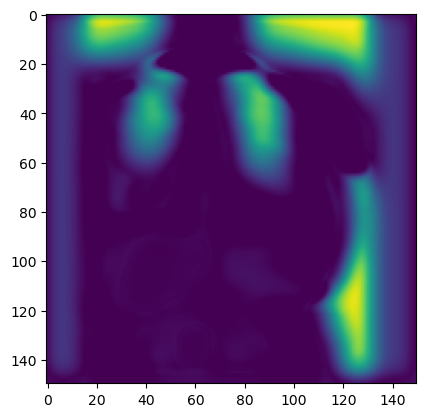

In [68]:
import keras
bestModel = keras.models.load_model("model_0.h5")
img = cv2.imread(os.path.join("..","dataLake","3e8719d1ba69b36c24ad3e39a8dd83ed.png"))
img = img/255;
image = np.expand_dims(img, axis=0)
target_layer = bestModel.get_layer("re_lu_6")
sub_model = tf.keras.models.Model(bestModel.inputs, [target_layer.output, bestModel.output])
pred_index = None

with tf.GradientTape() as tape:
    last_conv_out, preds = sub_model(image)
    tape.watch(last_conv_out)
    target_class = preds[0][0]

grads = tape.gradient(target_class, last_conv_out)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

last_conv_out = last_conv_out[0]
heatmap = last_conv_out @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

plt.imshow(heatmap)

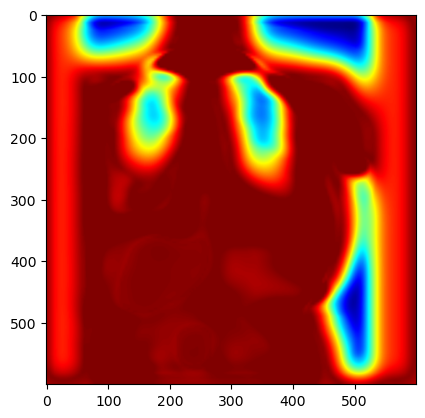

In [69]:
heatmap_resized = tf.image.resize(tf.expand_dims(heatmap, axis=-1), size=(img.shape[0], img.shape[1]))
heatmap_normalized = heatmap_resized / tf.math.reduce_max(heatmap_resized)
heatmap_normalized = tf.image.resize(heatmap_normalized, (600,600))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_normalized[..., 0]), cv2.COLORMAP_JET)
plt.imshow(heatmap_colored)

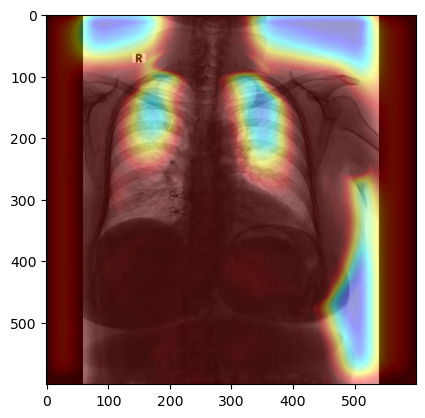

In [77]:
img = img*255
img = img.astype(np.uint8)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)
plt.imshow(superimposed_img)

In [2]:
import openai
import os

openai.organization = os.getenv("OPEN_AI_ORG")
openai.api_key = os.getenv("OPEN_AI_API_KEY")

prompt = "Pneumonia detected in upper left lobe in chest X-ray scan. Give details on this disease and does the detection location have any bearing on the diagnosis."

response = openai.Completion.create(
    engine="text-davinci-003",
    prompt = prompt,
    max_tokens = 1024
)

disease_details = response.choices[0].text
print(disease_details)



Pneumonia is an infection of the lungs which accumulates with fluid and pus. Pneumonia is typically caused by bacteria, viruses, fungi or chemical irritants and is spread through breathing, coughing and sneezing. Common symptoms of pneumonia include a persistent cough, difficulty breathing, fever, and chills.

The detection location can be a factor in the diagnosis of pneumonia as it can dictate how the treatment plan might be structured. For example, if the pneumonia is detected in the upper left lobe of the lung, it might require antibiotics that are able to effectively penetrate this area of the lung. Other treatments, such as physical therapy, may also need to be modified due to the localization of the infection.
